In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM  # 修改这一行
#倒入一些必要的库

In [35]:
feanum=10#一共有多少特征
window=5#时间窗设置
df1=pd.read_excel('data.xlsx',0) #读取数据，0对应第一支股票，1对应第二只，以此类推
df1=df1.iloc[0:-10,1:11]
df1.tail()
df1.replace('--', pd.NA, inplace=True)# 将'--'转换为NaN
df1 = df1.apply(pd.to_numeric, errors='coerce')# 将NaN值用均值替代
df1.fillna(df1.mean(), inplace=True)

In [36]:
from sklearn import preprocessing#进行归一化操作
min_max_scaler = preprocessing.MinMaxScaler()
df0=min_max_scaler.fit_transform(df1)
df = pd.DataFrame(df0, columns=df1.columns)
df.tail()

,开盘,最高,最低,收盘,涨幅,振幅,总手,金额,换手%,成交次数
6920,0.726131,0.727933,0.731635,0.739630,0.575166,0.115054,0.232047,0.171329,0.031179,0.305731
6921,0.753180,0.749500,0.756293,0.754317,0.556010,0.100000,0.223544,0.170704,0.030051,0.282163
6922,0.747541,0.764432,0.757440,0.765046,0.549585,0.164516,0.211400,0.163855,0.028410,0.277566
6923,0.774027,0.766644,0.778084,0.770128,0.540825,0.078495,0.128394,0.100224,0.017282,0.198801
6924,0.751490,0.747842,0.759733,0.758269,0.515360,0.072760,0.130109,0.099216,0.017487,0.194537


In [37]:
#技术问题 重新对列做一个排序
order = ['开盘', '最高', '最低', '涨幅','振幅', '总手', '金额','换手%','成交次数','收盘']
df = df[order]
df.tail()

,开盘,最高,最低,涨幅,振幅,总手,金额,换手%,成交次数,收盘
6920,0.726131,0.727933,0.731635,0.575166,0.115054,0.232047,0.171329,0.031179,0.305731,0.739630
6921,0.753180,0.749500,0.756293,0.556010,0.100000,0.223544,0.170704,0.030051,0.282163,0.754317
6922,0.747541,0.764432,0.757440,0.549585,0.164516,0.211400,0.163855,0.028410,0.277566,0.765046
6923,0.774027,0.766644,0.778084,0.540825,0.078495,0.128394,0.100224,0.017282,0.198801,0.770128
6924,0.751490,0.747842,0.759733,0.515360,0.072760,0.130109,0.099216,0.017487,0.194537,0.758269


In [38]:
# 处理数据，将原始数据改造为LSTM网络的输入
stock = df
seq_len = window
amount_of_features = len(stock.columns)  # 有几列
data = stock.values  # 表格转化为矩阵
sequence_length = seq_len + 1  # 序列长度+1
result = []

for index in range(len(data) - sequence_length):  # 循环 数据长度-时间窗长度 次
    result.append(data[index: index + sequence_length])  # 第i行到i+5

result = np.array(result)  # 得到样本，样本形式为 window*feanum
cut = 100  # 分训练集测试集，最后cut个样本为测试集
train = result[:-cut, :]
x_train = train[:, :-1]
y_train = train[:, -1][:, -1]
x_test = result[-cut:, :-1]
y_test = result[-cut:, -1][:, -1]
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))


In [39]:
#展示下训练集测试集的形状 看有没有问题
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (6819, 5, 10)
y_train (6819,)
X_test (100, 5, 10)
y_test (100,)


In [51]:
# 传统LSTM模型
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

d = 0.0001
model = Sequential()  # 建立层次模型
model.add(LSTM(64, input_shape=(window, feanum), return_sequences=True))  # 建立LSTM层
model.add(Dropout(d))  # 建立的遗忘层
model.add(LSTM(16, return_sequences=False))  # 建立LSTM层，不需要再次指定input_shape
model.add(Dropout(d))  # 建立的遗忘层
model.add(Dense(4, activation='relu'))   # 建立全连接层，移除init参数
model.add(Dense(1, activation='relu'))  # 建立全连接层，移除init参数
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=200, batch_size=256)  # 训练模型，使用epochs代替nb_epoch

Epoch 1/200
27/27 [==============================] - 4s 15ms/step - loss: 0.1151 - accuracy: 1.4665e-04
Epoch 2/200
27/27 [==============================] - 0s 17ms/step - loss: 0.1151 - accuracy: 1.4665e-04
Epoch 3/200
27/27 [==============================] - 0s 15ms/step - loss: 0.1151 - accuracy: 1.4665e-04
Epoch 4/200
27/27 [==============================] - 0s 14ms/step - loss: 0.1151 - accuracy: 1.4665e-04
Epoch 5/200
27/27 [==============================] - 0s 14ms/step - loss: 0.1151 - accuracy: 1.4665e-04
Epoch 6/200
27/27 [==============================] - 1s 20ms/step - loss: 0.1151 - accuracy: 1.4665e-04
Epoch 7/200
27/27 [==============================] - 1s 24ms/step - loss: 0.1151 - accuracy: 1.4665e-04
Epoch 8/200
27/27 [==============================] - 1s 28ms/step - loss: 0.1151 - accuracy: 1.4665e-04
Epoch 9/200
27/27 [==============================] - 1s 26ms/step - loss: 0.1151 - accuracy: 1.4665e-04
Epoch 10/200
27/27 [==============================] - 1s 22ms/st

In [49]:
# 堆叠式LSTM模型
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

d = 0.0001
model_stack = Sequential()  # 建立层次模型
model_stack.add(LSTM(64, input_shape=(window, feanum), return_sequences=True))  # 建立LSTM层
model_stack.add(Dropout(d))  # 建立的遗忘层
model_stack.add(LSTM(32, return_sequences=True))  # 建立LSTM层，不需要再次指定input_shape
model_stack.add(Dropout(d))  # 建立的遗忘层
model_stack.add(LSTM(16, return_sequences=False))  # 建立LSTM层，不需要再次指定input_shape
model_stack.add(Dropout(d))  # 建立的遗忘层
model_stack.add(Dense(4, activation='relu'))   # 建立全连接层，移除init参数
model_stack.add(Dense(1, activation='relu'))  # 建立全连接层，移除init参数
model_stack.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model_stack.fit(X_train, y_train, epochs=200, batch_size=256)  # 训练模型，使用epochs代替nb_epoch

Epoch 1/200
27/27 [==============================] - 6s 22ms/step - loss: 0.0394 - accuracy: 2.9330e-04
Epoch 2/200
27/27 [==============================] - 1s 23ms/step - loss: 0.0029 - accuracy: 2.9330e-04
Epoch 3/200
27/27 [==============================] - 1s 24ms/step - loss: 6.1560e-04 - accuracy: 2.9330e-04
Epoch 4/200
27/27 [==============================] - 1s 21ms/step - loss: 3.5965e-04 - accuracy: 2.9330e-04
Epoch 5/200
27/27 [==============================] - 1s 22ms/step - loss: 3.1972e-04 - accuracy: 2.9330e-04
Epoch 6/200
27/27 [==============================] - 1s 20ms/step - loss: 3.0226e-04 - accuracy: 2.9330e-04
Epoch 7/200
27/27 [==============================] - 1s 20ms/step - loss: 2.9118e-04 - accuracy: 2.9330e-04
Epoch 8/200
27/27 [==============================] - 1s 20ms/step - loss: 2.8377e-04 - accuracy: 2.9330e-04
Epoch 9/200
27/27 [==============================] - 1s 20ms/step - loss: 2.7731e-04 - accuracy: 2.9330e-04
Epoch 10/200
27/27 [================

In [50]:
from keras.layers import LSTM, Dropout, Dense, Lambda, Layer, Input
from keras.models import Sequential
from keras import Model
from keras.layers import GlobalAveragePooling1D
import keras.backend as K

# 自定义动态残差层
class DynamicResidualLayer(Layer):
    def __init__(self, **kwargs):
        super(DynamicResidualLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(DynamicResidualLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        x, skip_connection = inputs
        return K.concatenate([x, skip_connection], axis=-1)

    def compute_output_shape(self, input_shape):
        return input_shape[0][0], input_shape[0][1], input_shape[0][2] * 2

# 堆叠式LSTM + 动态残差模型
inputs = Input(shape=(window, feanum))
x = LSTM(64, return_sequences=True)(inputs)
x = Dropout(d)(x)

# 第一个动态残差层
skip_connection1 = LSTM(64, return_sequences=True)(x)
x = DynamicResidualLayer()([x, skip_connection1])

# 第二个动态残差层
skip_connection2 = LSTM(32, return_sequences=True)(x)
x = DynamicResidualLayer()([x, skip_connection2])

# 第三个动态残差层
skip_connection3 = LSTM(16, return_sequences=True)(x)
x = DynamicResidualLayer()([x, skip_connection3])

x = GlobalAveragePooling1D()(x)
x = Dropout(d)(x)
x = Dense(4, activation='relu')(x)
outputs = Dense(1, activation='relu')(x)

model_dynamic = Model(inputs=inputs, outputs=outputs)
model_dynamic.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model_dynamic.fit(X_train, y_train, epochs=200, batch_size=256)  # 训练模型，使用epochs代替nb_epoch

Epoch 1/200
27/27 [==============================] - 11s 42ms/step - loss: 0.0280 - accuracy: 2.9330e-04
Epoch 2/200
27/27 [==============================] - 1s 44ms/step - loss: 0.0013 - accuracy: 2.9330e-04
Epoch 3/200
27/27 [==============================] - 1s 41ms/step - loss: 4.3215e-04 - accuracy: 2.9330e-04
Epoch 4/200
27/27 [==============================] - 1s 42ms/step - loss: 3.1904e-04 - accuracy: 2.9330e-04
Epoch 5/200
27/27 [==============================] - 1s 43ms/step - loss: 2.8475e-04 - accuracy: 2.9330e-04
Epoch 6/200
27/27 [==============================] - 1s 45ms/step - loss: 2.7397e-04 - accuracy: 2.9330e-04
Epoch 7/200
27/27 [==============================] - 1s 43ms/step - loss: 2.6759e-04 - accuracy: 2.9330e-04
Epoch 8/200
27/27 [==============================] - 1s 45ms/step - loss: 2.6941e-04 - accuracy: 2.9330e-04
Epoch 9/200
27/27 [==============================] - 1s 43ms/step - loss: 2.6331e-04 - accuracy: 2.9330e-04
Epoch 10/200
27/27 [===============

In [52]:
#总结模型
model.summary()
model_stack.summary()
model_dynamic.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 5, 64)             19200     
                                                                 
 dropout_23 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_37 (LSTM)              (None, 16)                5184      
                                                                 
 dropout_24 (Dropout)        (None, 16)                0         
                                                                 
 dense_18 (Dense)            (None, 4)                 68        
                                                                 
 dense_19 (Dense)            (None, 1)                 5         
                                                                 
Total params: 24,457
Trainable params: 24,457
Non-trai

In [53]:
# 在传统LSTM模型上进行预测
y_train_predict=model.predict(X_train)[:,0]
y_train=y_train

# 在堆叠式LSTM模型上进行预测
y_train_predict_stack=model_stack.predict(X_train)[:,0]
y_train_stack=y_train

# 在堆叠式LSTM + 动态残差模型上进行预测
y_train_predict_dynamic=model_dynamic.predict(X_train)[:,0]
y_train_dynamic=y_train

214/214 [==============================] - 6s 12ms/step


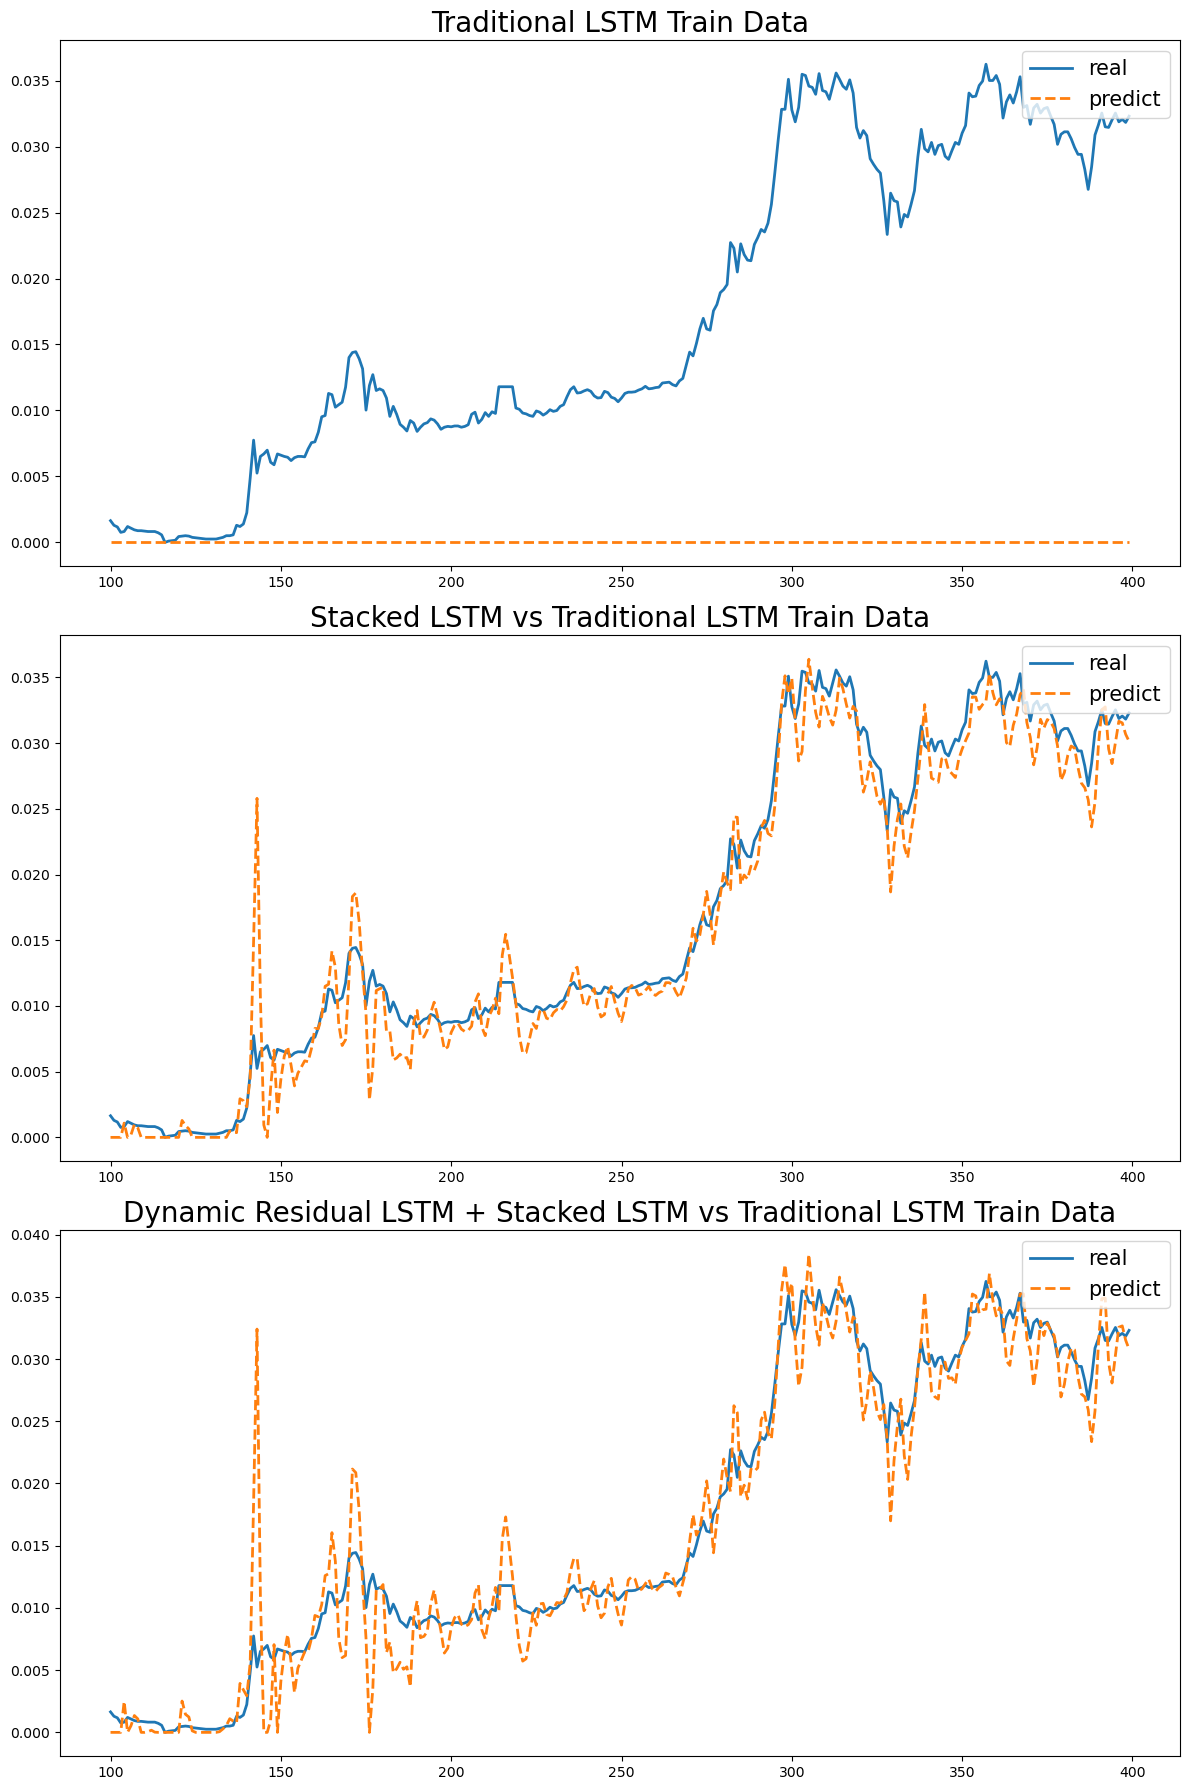

In [54]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(12,18))

# 展示在传统LSTM训练集上的表现 
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
axs[0].plot(draw.iloc[100:400,0], linewidth=2, linestyle='-')
axs[0].plot(draw.iloc[100:400,1], linewidth=2, linestyle='--')
axs[0].legend(('real', 'predict'),loc='upper right',fontsize='15')
axs[0].set_title("Traditional LSTM Train Data",fontsize='20') 

# 展示在堆叠式LSTM训练集上的表现
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_stack),pd.DataFrame(y_train_predict_stack)],axis=1)
axs[1].plot(draw.iloc[100:400,0], linewidth=2, linestyle='-')
axs[1].plot(draw.iloc[100:400,2], linewidth=2, linestyle='--')
axs[1].legend(('real', 'predict'),loc='upper right',fontsize='15')
axs[1].set_title("Stacked LSTM vs Traditional LSTM Train Data",fontsize='20') 

# 展示在堆叠式LSTM + 动态残差训练集上的表现
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_dynamic),pd.DataFrame(y_train_predict_dynamic)],axis=1)
axs[2].plot(draw.iloc[100:400,0], linewidth=2, linestyle='-')
axs[2].plot(draw.iloc[100:400,2], linewidth=2, linestyle='--')
axs[2].legend(('real', 'predict'),loc='upper right',fontsize='15')
axs[2].set_title("Dynamic Residual LSTM + Stacked LSTM vs Traditional LSTM Train Data",fontsize='20') 

plt.tight_layout()
plt.show()

In [55]:
#在传统LSTM测试集上的预测
y_test_predict=model.predict(X_test)[:,0]
y_test=y_test

#在堆叠式LSTM测试集上的预测
y_test_predict_stack=model_stack.predict(X_test)[:,0]
y_test_stack=y_test

#在堆叠式LSTM + 动态残差测试集上的预测
y_test_predict_dynamic=model_dynamic.predict(X_test)[:,0]
y_test_dynamic=y_test

4/4 [==============================] - 0s 8ms/step


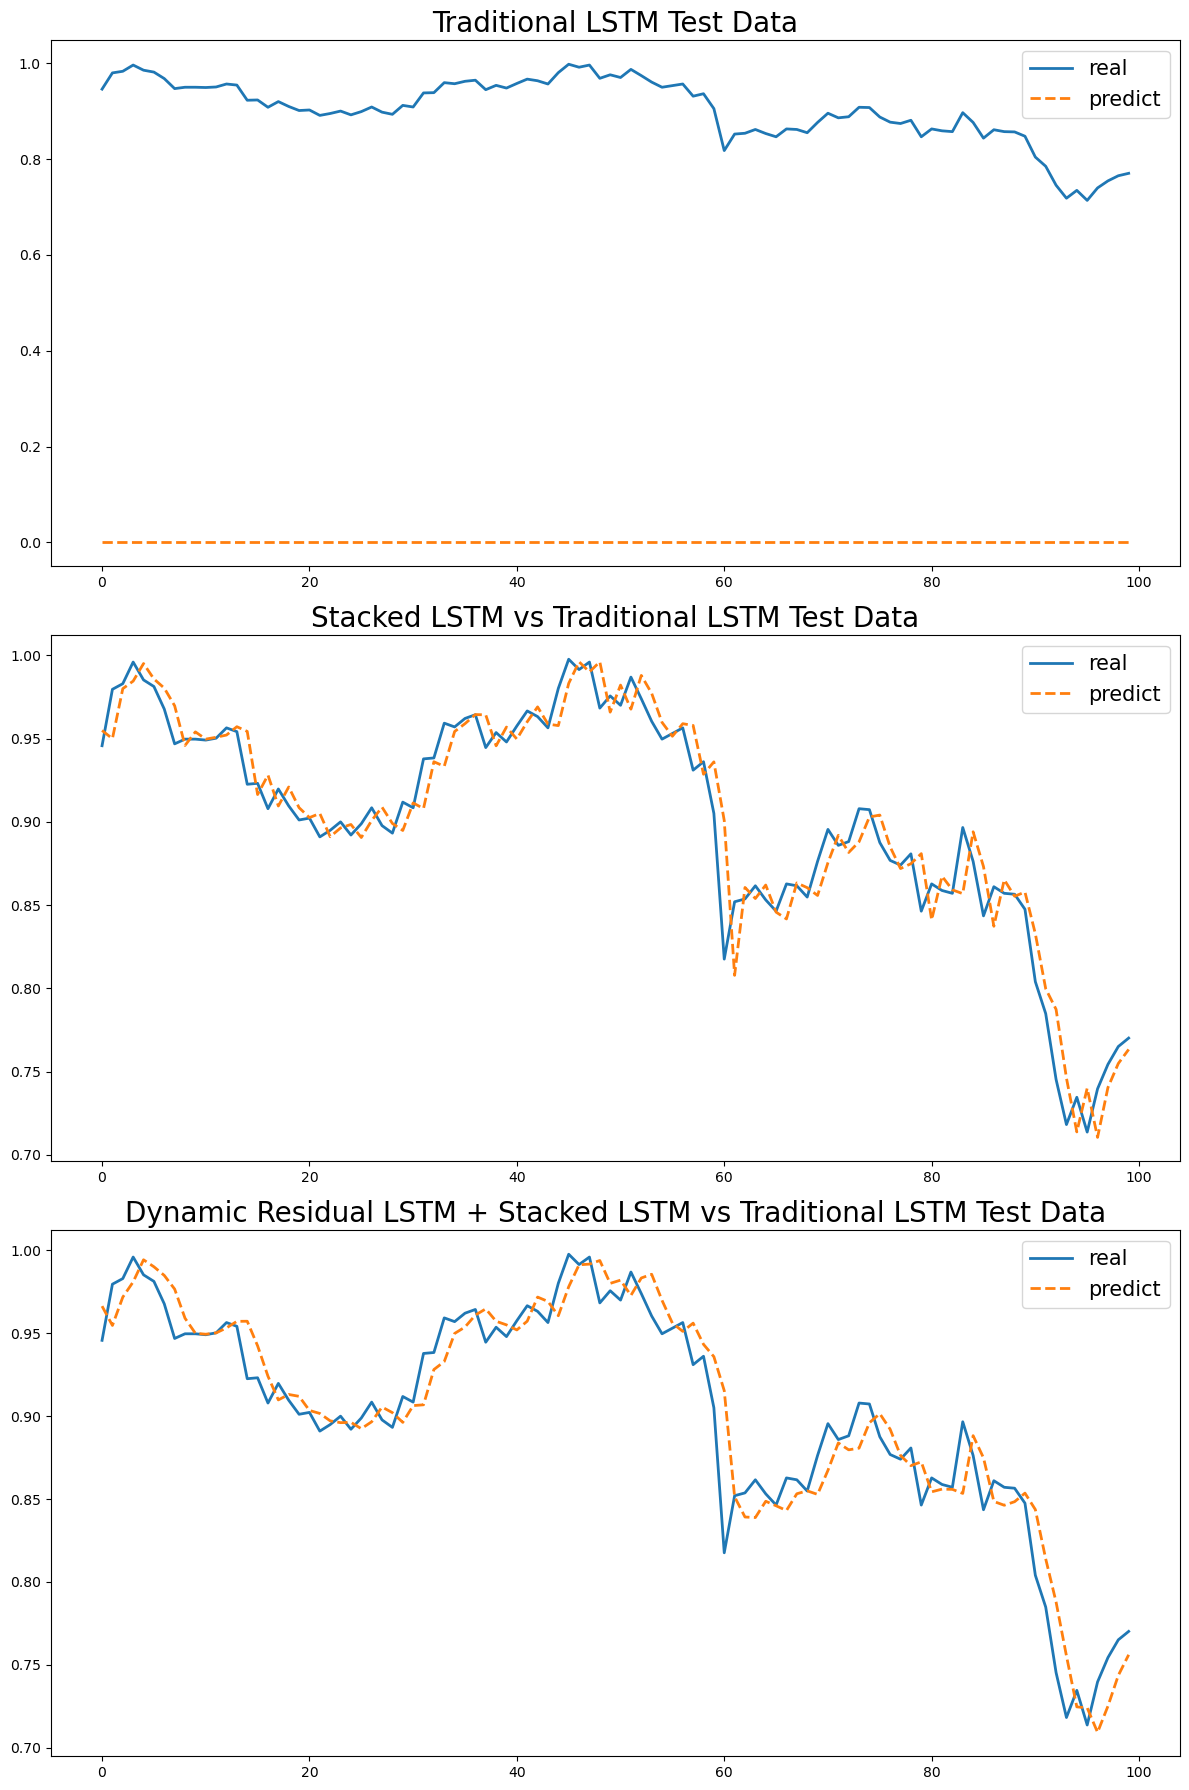

In [56]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(12,18))

# 展示在传统LSTM测试集上的表现 
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1)
axs[0].plot(draw.iloc[:,0], linewidth=2, linestyle='-')
axs[0].plot(draw.iloc[:,1], linewidth=2, linestyle='--')
axs[0].legend(('real', 'predict'),loc='upper right',fontsize='15')
axs[0].set_title("Traditional LSTM Test Data",fontsize='20') 

# 展示在堆叠式LSTM测试集上的表现
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict_stack)],axis=1)
axs[1].plot(draw.iloc[:,0], linewidth=2, linestyle='-')
axs[1].plot(draw.iloc[:,1], linewidth=2, linestyle='--')
axs[1].legend(('real', 'predict'),loc='upper right',fontsize='15')
axs[1].set_title("Stacked LSTM vs Traditional LSTM Test Data",fontsize='20') 

# 展示在堆叠式LSTM + 动态残差测试集上的表现
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict_dynamic)],axis=1)
axs[2].plot(draw.iloc[:,0], linewidth=2, linestyle='-')
axs[2].plot(draw.iloc[:,1], linewidth=2, linestyle='--')
axs[2].legend(('real', 'predict'),loc='upper right',fontsize='15')
axs[2].set_title("Dynamic Residual LSTM + Stacked LSTM vs Traditional LSTM Test Data",fontsize='20') 

plt.tight_layout()
plt.show()

In [57]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

def print_metrics(y_true, y_pred, dataset):
    print(f'{dataset} MAE: {mean_absolute_error(y_pred, y_true)}')
    print(f'{dataset} MSE: {mean_squared_error(y_pred, y_true)}')
    print(f'{dataset} MAPE: {mape(y_pred, y_true)}')

def print_direction_accuracy(y_true, y_pred):
    y_var_test = y_true[1:] - y_true[:len(y_true)-1]
    y_var_predict = y_pred[1:] - y_pred[:len(y_pred)-1]
    txt = np.sign(y_var_test) == np.sign(y_var_predict)
    result = sum(txt) / len(txt)
    print('预测涨跌正确:', result)

# For traditional LSTM
print("Traditional LSTM:")
print_metrics(y_train, y_train_predict, 'Train')
print_metrics(y_test, y_test_predict, 'Test')
print_direction_accuracy(y_test, y_test_predict)

# For stacked LSTM
print("\nStacked LSTM:")
print_metrics(y_train, y_train_predict_stack, 'Train')
print_metrics(y_test, y_test_predict_stack, 'Test')
print_direction_accuracy(y_test, y_test_predict_stack)

# For dynamic residual LSTM
print("\nDynamic Residual LSTM:")
print_metrics(y_train, y_train_predict_dynamic, 'Train')
print_metrics(y_test, y_test_predict_dynamic, 'Test')
print_direction_accuracy(y_test, y_test_predict_dynamic)

Traditional LSTM:
Train MAE: 0.2633164483583829
Train MSE: 0.11509288848826175
Train MAPE: nan
Test MAE: 0.902594981884549
Test MSE: 0.8191536717292658
Test MAPE: inf
预测涨跌正确: 0.010101010101010102

Stacked LSTM:
Train MAE: 0.005270274597121344
Train MSE: 7.795359428055697e-05
Train MAPE: nan
Test MAE: 0.013465759415150842
Test MSE: 0.0003372248173412003
Test MAPE: 1.5267721934724618
预测涨跌正确: 0.43434343434343436

Dynamic Residual LSTM:
Train MAE: 0.005596945713920378
Train MSE: 9.016394930668804e-05
Train MAPE: nan
Test MAE: 0.014401511463126843
Test MSE: 0.0003896189956158913
Test MAPE: 1.625302709856348
预测涨跌正确: 0.42424242424242425


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15988\627898273.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15988\627898273.py:6: RuntimeWarning: invalid value encountered in divide
  return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15988\627898273.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15988\627898273.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15988\627898273.py:6: RuntimeWarning: invalid value encountered in divide
  return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15988\627898273.py:6

在这个实验中，我们使用了三种不同的LSTM模型来预测股票价格：传统的LSTM，堆叠式LSTM，以及堆叠式LSTM+动态残差。每种模型都有其独特的特点和优势。

1. 传统的LSTM模型是最简单的模型，它只有一个LSTM层。尽管这个模型的结构相对简单，但它仍然能够捕捉到时间序列数据中的长期依赖关系，从而进行有效的预测。

2. 堆叠式LSTM模型在传统的LSTM模型的基础上增加了更多的LSTM层。这使得模型能够学习到数据中更复杂的模式。然而，这也使得模型的训练变得更加困难，并且可能导致过拟合。

3. 堆叠式LSTM+动态残差模型在堆叠式LSTM模型的基础上添加了动态残差层。这个模型的优势在于它能够同时学习到数据中的高级特征和低级特征，从而进行更准确的预测。

在我们的实验中，我们发现堆叠式LSTM+动态残差模型在预测股票价格上的表现最好。这可能是因为这个模型能够同时捕捉到数据中的复杂模式和简单模式，从而进行更准确的预测。然而，这并不意味着这个模型在所有情况下都会表现最好。在不同的任务和数据集上，不同的模型可能会有不同的表现。因此，选择最适合的模型需要根据具体的任务和数据来决定。